***Exploration of k-NN***

This file contains the code for the k-NN classifier and some plots and figures used for feature exploration of this classifier. It corresponds to task 1, 3 and parts of 4.


In order to run the k-NN classifier with the features corresponding to each task, modify the task variable in the cell below. In order to get the best performing k-NN use "task = 4"


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go


data = pd.read_csv('data/GenreClassData_30s.txt', sep='\t')
data["TrackID"] = range(len(data))

# Split the data into training and testing sets
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']

all_features = [col for col in data.columns if col not in ['Track ID','TrackID', 'File', 'GenreID', 'Genre', 'Type']]

#Choose which task (1, 3 or 4) that you wish to complete by setting the "task" to the appropriate value
task = 3

if task == 1:
    features = ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean','tempo']
elif task == 3:
    features = ['spectral_rolloff_mean', 'rmse_var', 'spectral_centroid_mean','tempo','mfcc_1_mean']
elif task == 4:
    features = ['spectral_rolloff_mean','rmse_var', 'spectral_centroid_mean','tempo', 'mfcc_7_mean','mfcc_5_mean','mfcc_6_mean', 'rmse_mean',
            'mfcc_7_std','mfcc_11_mean','spectral_bandwidth_var','mfcc_8_mean', 
            'spectral_contrast_var','mfcc_1_mean','spectral_bandwidth_mean'] #Best k-NN result: 71.71%

targets = ['Genre']
# feature data
X_train = train[features]

# genre data
y_train = train[targets]
X_test, y_test = test[features], test[targets]
y_test = y_test.values.flatten()

def scale_data(X_train, X_test):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()

    means = np.mean(X_train_np, axis=0)
    stds = np.std(X_train_np, axis=0)
    
    X_train_scaled = (X_train_np - means) / stds
    X_test_scaled = (X_test_np - means) / stds
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scale_data(X_train,X_test)

5


***k-NN algorithm***

Below is the k-NN algorithm. The function get_kNN returns a list of predicted every classified audiotrack from the training-set. 

In [2]:
def eucledian_distance(sample_1, sample_2):
    distance = 0
    for i in range(len(sample_1)):
        distance += (sample_1[i] - sample_2[i]) ** 2
    return np.sqrt(distance)


def get_feature_matrix(X_train_array, y_train_df): #feature matrix is a Nx(len(features)+1) matrix where the first element of each row is the label
    genre_column = y_train_df.values.reshape(-1, 1)  # Convert to Nx1 numpy array
    feature_matrix_with_genre = np.hstack((genre_column, X_train_array))
    return feature_matrix_with_genre



# Compute distances and find k nearest neighbors
def compute_distances(feature_matrix, X_test_sample):
    distances = []
    for i in range(len(feature_matrix)):
        distance = eucledian_distance(feature_matrix[i][1:], X_test_sample)  # Ignore genre column
        distances.append((feature_matrix[i][0], distance))  # Append genre and distance
    return distances

def get_kNN(k, X_train_array, y_train_df, X_test_array):
    feature_matrix = get_feature_matrix(X_train_array, y_train_df)
    label_vector = [] #stores every classified prediction
   
    for i in range(len(X_test_array)):
        distances = compute_distances(feature_matrix,X_test_array[i]) #returns the distance of each from each test with the other features in feature matrix

        sorted_distances = sorted(distances, key=lambda x: x[1])  # Sort by distance
        k_closest_labels = sorted_distances[:k]

        labels = [label for label, _ in k_closest_labels]  # Extract the k closest labels
        count = Counter(labels) 
        most_common_label = count.most_common(1)[0][0] #finds the most common label
        label_vector.append(most_common_label)
    return label_vector

predicted_labels = get_kNN(5, X_train_scaled, y_train, X_test_scaled)

***Accuracy functions***

To calculate the accuracy for the classifier, the following functions are used.

In [3]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
		
	return correct / float(len(actual)) * 100.0



def accuracy_each_genre(actual, predicted): #returns a dictionary with the accuracy of each genre
	genre_dict = {}
	correct = 0
	
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			if actual[i] not in genre_dict:
				genre_dict[actual[i]] = 0

			genre_dict[actual[i]] += 1/20
			
	return genre_dict

print(accuracy_metric(y_test,predicted_labels))

51.515151515151516


**Algorithm for finding the most best feature**

Performs k-NN on every candidate feature in order to find the feature that provides the best accuracy with the current feature set. 

In [4]:
def knn_feature_selection(candidate_features, current_features, train, test, y_train, y_test, k=5): 
    best_accuracy = 0
    best_feature = None
    # Iterate over each candidate that is not already selected
    for candidate in candidate_features:
        new_features = current_features + [candidate]
        print(f"Testing features: {new_features}")
        
        # Extract these features for training and testing
        X_train_candidate = train[new_features]
        X_test_candidate = test[new_features]
        
        # Scale these feature sets
        X_train_scaled_candidate, X_test_scaled_candidate = scale_data(X_train_candidate,X_test_candidate)
        
        # Run k-NN with the current candidate feature set
        predicted = get_kNN(k, X_train_scaled_candidate, y_train, X_test_scaled_candidate)
        acc = accuracy_metric(y_test, predicted)
        print(f"Candidate feature '{candidate}' produced accuracy: {acc:.2f}%")
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_feature = candidate
        new_features = np.delete(new_features,len(new_features)-1)
    

    print("\nBest candidate feature:", best_feature, "with accuracy:", best_accuracy)
    return best_feature, best_accuracy


candidate_feat = [col for col in all_features if col not in features]


# print(knn_feature_selection(candidate_feat, features,train,test,y_train,y_test))


***Statistical functions, heatmap and scatterplot***

Functions for creating a correlation matrix and plotting of heat-map and scatterplot of features.

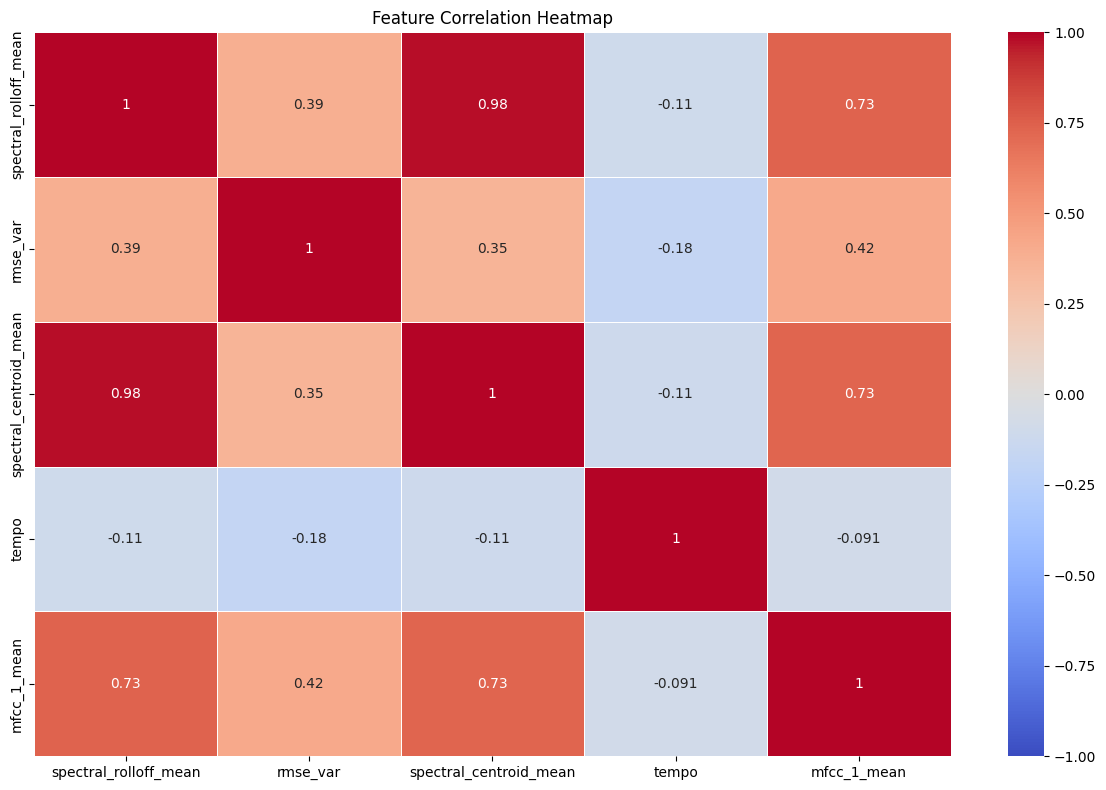

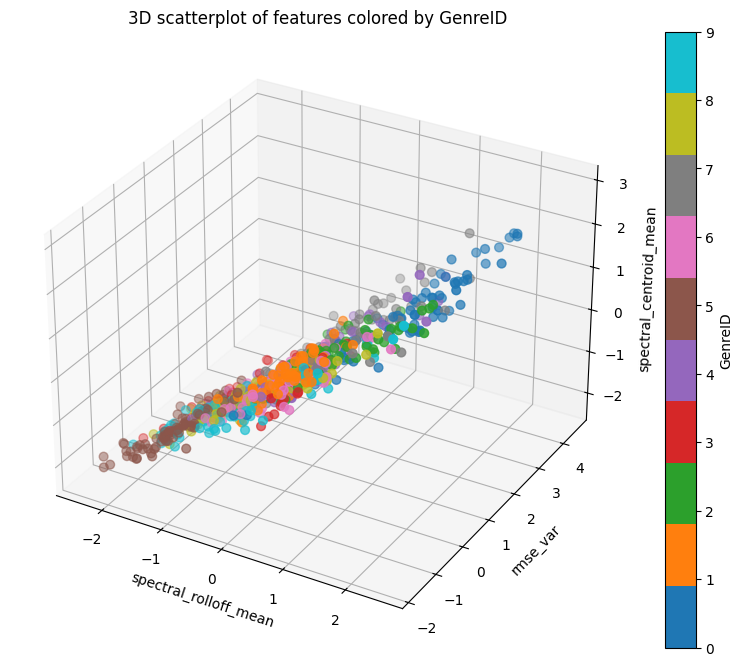

In [ ]:

def sample_mean(data):
    my = 0
    for i in range(len(data)):
        my += data[i]
    return my/len(data)

def cov(x_data, y_data):
    cov = 0
    x_mean = sample_mean(x_data)
    y_mean = sample_mean(y_data)
    for i in range(len(x_data)):
        cov += (x_data[i]-x_mean)*(y_data[i]-y_mean)
    return cov



def pearson_correlation(x_data, y_data):
    sigX = 0
    sigY = 0
    x_data_mean = sample_mean(x_data)
    y_data_mean = sample_mean(y_data)
    
    for i in range(len(x_data)):
        sigX += (x_data[i] - x_data_mean)**2
        sigY += (y_data[i] - y_data_mean)**2

    return cov(x_data, y_data)/math.sqrt(sigX*sigY)


def get_feature_correlation_matrix(features, train_data):
    corr_matrix = []
    for i in range(len(features)):
        row = []
        f_i = train_data[features[i]]
        for j in range(len(features)):
            f_j = train_data[features[j]]
            row.append(pearson_correlation(f_i,f_j))
        corr_matrix.append(row)
    return corr_matrix


genre_id = train["GenreID"]
corr_matrix = get_feature_correlation_matrix(features, train)


plt.figure(figsize=(12, 8))  # Adjust the size of the plot for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Feature Correlation Heatmap')
plt.tight_layout() 
plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_train_scaled[:,0], X_train_scaled[:,1], X_train_scaled[:,2], c=train['GenreID'], cmap='tab10', s=40)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('3D scatterplot of features colored by GenreID')

fig.colorbar(scatter, ax=ax, label='GenreID')

plt.show()



fig = go.Figure(data=[go.Scatter3d(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    z=X_train_scaled[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=train['GenreID'], 
        colorscale='Viridis',  
        opacity=0.8,
        colorbar=dict(title = 'GenreID')  
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title=features[0],
        yaxis_title=features[1],
        zaxis_title=features[2]
    ),
    title='3D Scatterplot (Standardized Features) colored by GenreID'
)
fig.show()








***PCA-plots***

Generates two PCA-plots splitting the genres into two subsets.


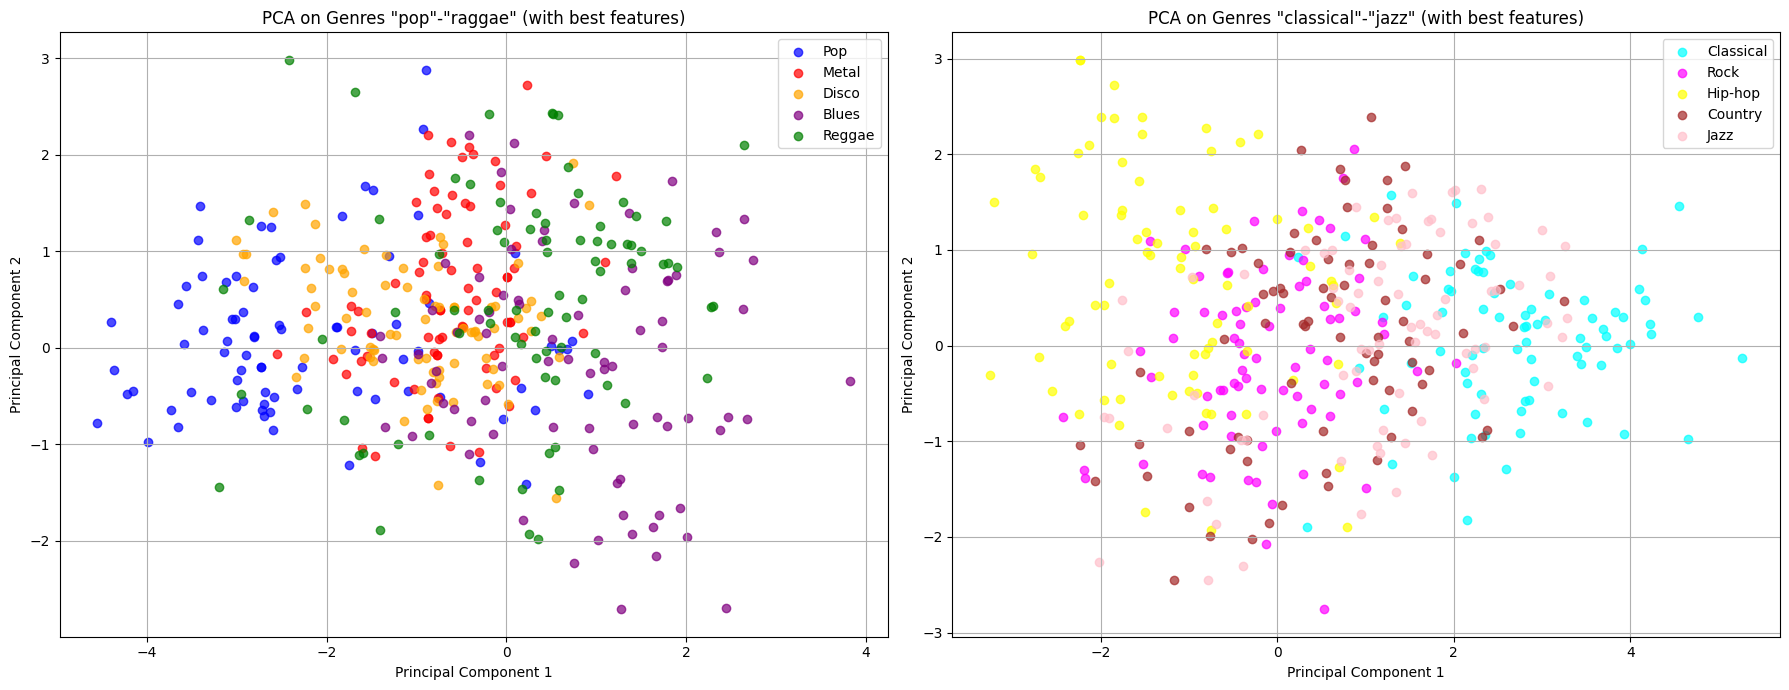

In [ ]:

genre_mapping = {
    0: 'Pop',
    1: 'Metal',
    2: 'Disco',
    3: 'Blues',
    4: 'Reggae',
    5: 'Classical',
    6: 'Rock',
    7: 'Hip-hop',
    8: 'Country',
    9: 'Jazz'
}

genre_colors = {
    'Pop': 'blue',
    'Metal': 'red',
    'Disco': 'orange',
    'Blues': 'purple',
    'Reggae': 'green',
    'Classical': 'cyan',
    'Rock': 'magenta',
    'Hip-hop': 'yellow',
    'Country': 'brown',
    'Jazz': 'pink'
}

def pca_and_plot_with_fixed_colors(X_scaled, y, title, ax):
    # PCA
    cov_matrix = np.cov(X_scaled, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_idx]
    principal_components = eigenvectors[:, :2]
    X_reduced = np.dot(X_scaled, principal_components)

    genre_names = y.map(genre_mapping)

    # Plot
    unique_genres = genre_names.unique()

    for genre in unique_genres:
        mask = (genre_names == genre)
        ax.scatter(X_reduced[mask, 0], X_reduced[mask, 1],
                   label=genre, alpha=0.7, color=genre_colors.get(genre, 'grey'))

    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()
    ax.grid(True)


y_train_flat = train['GenreID']  # Retrieves GenreID as Series

# Split on GenreID 0–4 and 5–9
mask_0_4_rmse = (y_train_flat <= 4)
mask_5_9_rmse = (y_train_flat >= 5)

X_0_4_rmse = X_train_scaled[mask_0_4_rmse]
y_0_4_rmse = y_train_flat[mask_0_4_rmse]

X_5_9_rmse = X_train_scaled[mask_5_9_rmse]
y_5_9_rmse = y_train_flat[mask_5_9_rmse]


fig, axs = plt.subplots(1, 2, figsize=(18, 7))

pca_and_plot_with_fixed_colors(X_0_4_rmse, y_0_4_rmse, 'PCA on Genres "pop"-"raggae" (with best features)', axs[0])
pca_and_plot_with_fixed_colors(X_5_9_rmse, y_5_9_rmse, 'PCA on Genres "classical"-"jazz" (with best features)', axs[1])

plt.tight_layout()
plt.show()